In [ ]:
!pip install -U transformers==4.57.0

In [ ]:
import pandas as pd
from transformers import AutoModel, AutoTokenizer, AutoModelForMaskedLM, AutoFeatureExtractor
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import requests
from io import BytesIO
from torchvision import transforms
from sklearn.model_selection import train_test_split
import numpy as np
import torch.optim as optim
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
import hashlib
from datetime import datetime

In [ ]:
# import shutil, os

# # Be absolutely sure before running this
# for item in os.listdir("/kaggle/working"):
#     item_path = os.path.join("/kaggle/working", item)
#     try:
#         if os.path.isfile(item_path) or os.path.islink(item_path):
#             os.unlink(item_path)  # remove file or symlink
#         elif os.path.isdir(item_path):
#             shutil.rmtree(item_path)  # remove folder
#     except Exception as e:
#         print(f"Failed to delete {item_path}: {e}")

# print("✅ /kaggle/working has been emptied.")

In [ ]:
import transformers
print(transformers.__version__)

In [ ]:
os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [ ]:
df = pd.read_csv(r"/kaggle/input/amazon-ml-challenge-2025-dataset/train.csv")
df.head()

In [ ]:
df.shape

In [ ]:
def extract_value_unit(text):
    value_match = re.search(r"Value:\s*([\d.]+)", text)
    unit_match = re.search(r"Unit:\s*([a-zA-Z]+)", text)
    
    value = float(value_match.group(1)) if value_match else None
    unit = unit_match.group(1) if unit_match else None
    return pd.Series([value, unit])

In [ ]:
def clean_text(text):
    if pd.isna(text):
        return text
    text = str(text)

    # Remove unwanted prefixes
    text = re.sub(r"(?i)\bItem Name:\s*", "", text)
    text = re.sub(r"(?i)\bBullet Point\s*\d*:\s*", "", text)
    text = re.sub(r"(?i)\bProduct Description:\s*", "", text)
    text = re.sub(r"(?i)\bValue:\s*[\d.]+\b", "", text)
    text = re.sub(r"(?i)\bUnit:\s*[a-zA-Z]+\b", "", text)

    # Remove HTML tags
    text = re.sub(r"<[^>]+>", "", text)

    # Remove extra spaces or newlines
    text = re.sub(r"\s+", " ", text).strip()

    return text

In [ ]:
df[['Value', 'Unit']] = df['catalog_content'].apply(extract_value_unit)
df["catalog_content"] = df["catalog_content"].apply(clean_text)
df.head()

In [ ]:
df.Unit.isna().sum()

In [ ]:
df.Unit.describe()

In [ ]:
df['Unit'].mode()[0]

In [ ]:
df['Value'].median()

In [ ]:
df.Value.isna().sum()

In [ ]:
df.Value.describe()

In [ ]:
df['Unit'] = df['Unit'].fillna('None')
df['Value'] = df['Value'].fillna(df['Value'].median())

In [ ]:
le = LabelEncoder()
df['Unit'] = le.fit_transform(df['Unit'])

unit_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print("Unit mapping:", unit_mapping)

In [ ]:
scaler = StandardScaler()
df['Value'] = scaler.fit_transform(df[['Value']])

In [ ]:
plt.figure(figsize=(12, 5))

# Raw price histogram
plt.subplot(1, 2, 1)
sns.histplot(df.price, bins=60, color='teal', alpha=0.7, edgecolor='black')
plt.title("Original Price Distribution")
plt.xlabel("Price")
plt.ylabel("Frequency")

# Boxplot to detect outliers
plt.subplot(1, 2, 2)
sns.boxplot(x=df.price, color='orange')
plt.title("Boxplot of Prices")
plt.xlabel("Price")

plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(10,6))
sns.histplot(df['price'], bins=50, kde=True, color='skyblue')
plt.title('Price Distribution', fontsize=16)
plt.xlabel('Price', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(alpha=0.3)
plt.show()

In [ ]:
plt.figure(figsize=(10,6))
sns.histplot(np.log1p(df['price']), bins=50, kde=True, color='orange')
plt.title('Log-Scaled Price Distribution', fontsize=16)
plt.xlabel('Log(Price + 1)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(alpha=0.3)
plt.show()

In [ ]:
Q1 = np.percentile(df.price, 25)
Q3 = np.percentile(df.price, 75)
IQR = Q3 - Q1

lower_limit = Q1 - 1.5 * IQR
upper_limit = Q3 + 1.5 * IQR

print(f"Price range (IQR-based): {lower_limit:.2f} to {upper_limit:.2f}")

In [ ]:
lower_percentile = 1
upper_percentile = 99
lower_clip = np.percentile(df.price, lower_percentile)
upper_clip = np.percentile(df.price, upper_percentile)

print(f"Clipping range (1st–99th percentile): {lower_clip:.2f} to {upper_clip:.2f}")
print(df.price.describe())

In [ ]:
clipped_prices = np.clip(df.price, lower_clip, upper_clip)

plt.figure(figsize=(10, 5))
sns.histplot(np.log1p(clipped_prices), bins=50, kde=True, color='coral', alpha=0.7)
plt.title("Log-Scaled Price Distribution (After Clipping)")
plt.xlabel("log(Price + 1)")
plt.ylabel("Frequency")
plt.show()

In [ ]:
lower_limit =  1.32
upper_limit = 145.25

# Keep only rows within the desired range
filtered_df = df[(df["price"] >= lower_limit) & (df["price"] <= upper_limit)].copy()

print(f"Original dataset size: {len(df)}")
print(f"After filtering: {len(filtered_df)}")
print(f"Rows removed: {len(df) - len(filtered_df)} ({(1 - len(filtered_df)/len(df))*100:.2f}% removed)")
print(f'Total rows under lower bound: {len(df[(df["price"] < lower_limit)])}')
print(f'Total rows above upper bound: {len(df[(df["price"] > upper_limit)])}')

In [ ]:
sns.histplot(np.log1p(filtered_df["price"]), bins=50, kde=True, color='green')
plt.title("Log(Price + 1) Distribution After Outlier Removal")
plt.xlabel("log(Price + 1)")
plt.ylabel("Frequency")
plt.show()

In [ ]:
df = df[(df["price"] >= lower_limit) & (df["price"] <= upper_limit)].copy()
actual_price = df.price
df["log_price"] = np.log1p(df["price"])
df.drop(columns=["price","sample_id"], inplace=True)
total_rows = len(df)
train_rows = int(total_rows * 0.8)
val_rows = total_rows - train_rows

print(f"Final number of training rows: {train_rows}")
print(f"Final number of validation rows: {val_rows}")
print(f"Final number of total rows: {total_rows}")

In [ ]:
plt.figure(figsize=(10,6))
sns.histplot(df['log_price'], bins=50, kde=True, color='orange')
plt.title('Log-Scaled Price Distribution', fontsize=16)
plt.xlabel('Log(Price + 1)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(alpha=0.3)
plt.show()

In [53]:
df_ = df.sample(n=15000, random_state=42).reset_index(drop=True)

In [ ]:
plt.figure(figsize=(10,6))
sns.histplot(df_['log_price'], bins=50, kde=True, color='orange')
plt.title('Log-Scaled Price Distribution', fontsize=16)
plt.xlabel('Log(Price + 1)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(alpha=0.3)
plt.show()

In [54]:
tokenizer = AutoTokenizer.from_pretrained("answerdotai/ModernBERT-base")
token_lengths = [len(tokenizer.encode(text, add_special_tokens=True)) for text in df['catalog_content']]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/694 [00:00<?, ?B/s]

Min tokens: 4
Max tokens: 1697
Median tokens: 137.0
Mean tokens: 200.34546666666665
90th percentile: 509.0
95th percentile: 586.0499999999993
99th percentile: 834.0


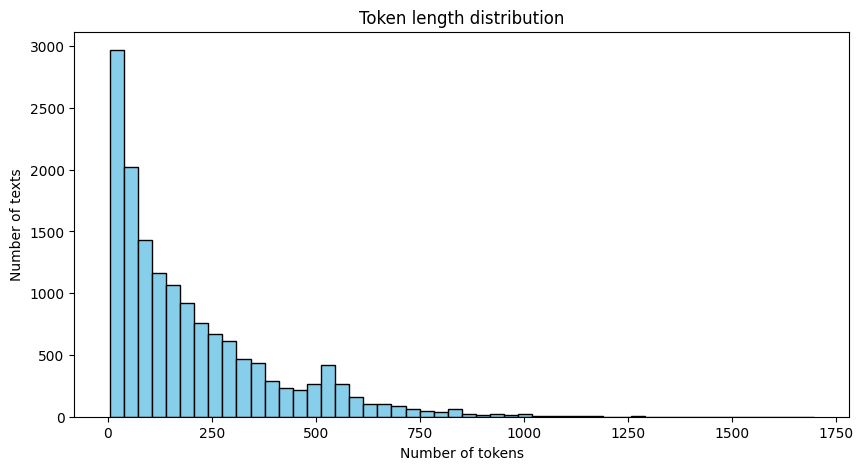

In [55]:
# Convert to NumPy array for convenience
token_lengths = np.array(token_lengths)

# Basic statistics
print("Min tokens:", token_lengths.min())
print("Max tokens:", token_lengths.max())
print("Median tokens:", np.median(token_lengths))
print("Mean tokens:", np.mean(token_lengths))
print("90th percentile:", np.percentile(token_lengths, 90))
print("95th percentile:", np.percentile(token_lengths, 95))
print("99th percentile:", np.percentile(token_lengths, 99))

# Histogram
plt.figure(figsize=(10,5))
plt.hist(token_lengths, bins=50, color='skyblue', edgecolor='black')
plt.title("Token length distribution")
plt.xlabel("Number of tokens")
plt.ylabel("Number of texts")
plt.show()

In [56]:
max_len_optimal = 196

def batch_tokenize(texts, batch_size=256, max_len=512):
    all_input_ids, all_attention_masks = [], []
    for i in range(0, len(texts), batch_size):
        enc = tokenizer(
            texts[i:i+batch_size].tolist(),
            padding='max_length',
            truncation=True,
            max_length=max_len,
            return_tensors='pt'
        )
        all_input_ids.append(enc['input_ids'])
        all_attention_masks.append(enc['attention_mask'])
    return torch.cat(all_input_ids, dim=0), torch.cat(all_attention_masks, dim=0)

input_ids_all, attention_mask_all = batch_tokenize(df['catalog_content'], batch_size=256, max_len=max_len_optimal)

prices_all = torch.from_numpy(df['log_price'].to_numpy()).float()

In [57]:
train_idx, val_idx = train_test_split(range(len(df)), test_size=0.2, random_state=42)

train_idx_torch = torch.tensor(train_idx, dtype=torch.long)
val_idx_torch = torch.tensor(val_idx, dtype=torch.long)

train_input_ids = input_ids_all[train_idx_torch]
train_attention_mask = attention_mask_all[train_idx_torch]
train_prices = prices_all[train_idx_torch]

val_input_ids = input_ids_all[val_idx_torch]
val_attention_mask = attention_mask_all[val_idx_torch]
val_prices = prices_all[val_idx_torch]

train_urls = df['image_link'].iloc[train_idx].to_numpy()
val_urls = df['image_link'].iloc[val_idx].to_numpy()

train_numeric = torch.tensor(df[['Value', 'Unit']].iloc[train_idx].values, dtype=torch.float32)
val_numeric = torch.tensor(df[['Value', 'Unit']].iloc[val_idx].values, dtype=torch.float32)

In [80]:
CACHE_DIR = "/kaggle/working/image_cache"
LOG_FILE = os.path.join(CACHE_DIR, "missing_images_log.txt")
os.makedirs(CACHE_DIR, exist_ok=True)

In [89]:
def load_image_cached(url, type_, cache_dir=CACHE_DIR):
    """
    Downloads an image from a URL once, caches it as JPEG, 
    and returns a PyTorch tensor ready for ViT.
    """
    # Generate unique filename from URL
    filename = hashlib.md5(url.encode()).hexdigest() + ".jpg"
    os.makedirs(f"{CACHE_DIR}/{type_}", exist_ok=True)
    filepath = os.path.join(cache_dir, type_, filename)
    
    if os.path.exists(filepath):
        # Load cached image
        img = Image.open(filepath).convert("RGB")
    else:
        # Download image
        try:
            response = requests.get(url, timeout=10)
            img = Image.open(BytesIO(response.content)).convert("RGB")
            img.save(filepath, format='JPEG', quality=85)
        except Exception as e:
            with open(LOG_FILE, "a") as f:
                f.write(f"[{datetime.now()}] Failed to load: {url} | Error: {e}\n")
                
            img = Image.new("RGB", (224,224), color=(0,0,0))
    
    return img

class MultimodalDataset(Dataset):
    def __init__(self, input_ids, attention_mask, urls, numeric_features, prices, type_, image_transform=None):
        self.input_ids = input_ids
        self.attention_mask = attention_mask
        self.urls = urls
        self.numeric_features = numeric_features
        self.prices = prices
        self.image_transform = image_transform
        self.type_ = type_

    def __len__(self):
        return len(self.urls)

    def __getitem__(self, idx):
        input_id = self.input_ids[idx]
        attention_mask = self.attention_mask[idx]

        image = load_image_cached(self.urls[idx], type_=self.type_)
        if self.image_transform:
            image = self.image_transform(image)

        numeric = self.numeric_features[idx]

        # print(type(self.prices[idx]))
        price = torch.tensor(self.prices[idx], dtype=torch.float32)

        return {
            'input_ids': input_id,
            'attention_mask': attention_mask,
            'pixel_values': image,
            'numeric_features': numeric,
            'labels': price.unsqueeze(-1)
        }

image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5])
])

# train_dataset = MultimodalDataset(
#     input_ids=train_input_ids,
#     attention_mask=train_attention_mask,
#     urls=train_urls,
#     numeric_features=train_numeric,
#     prices=train_prices,
#     type_="train",
#     image_transform=image_transform
# )

# val_dataset = MultimodalDataset(
#     input_ids=val_input_ids,
#     attention_mask=val_attention_mask,
#     urls=val_urls,
#     numeric_features=val_numeric,
#     prices=val_prices,
#     type_="val",
#     image_transform=image_transform
# )

# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
# val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)

In [60]:
def smape(y_true_log, y_pred_log):
    y_true = torch.expm1(y_true_log)
    y_pred = torch.expm1(y_pred_log)
    numerator = torch.abs(y_pred - y_true)
    denominator = (torch.abs(y_true) + torch.abs(y_pred)) / 2 + 1e-7
    return torch.mean(numerator / denominator) * 100

def mae(y_true_log, y_pred_log):
    y_true = torch.expm1(y_true_log)
    y_pred = torch.expm1(y_pred_log)
    return torch.mean(torch.abs(y_pred - y_true))

def smape_loss(y_true, y_pred, eps=1e-7):
    numerator = torch.abs(y_pred - y_true)
    denominator = (torch.abs(y_true) + torch.abs(y_pred)) / 2 + eps
    return torch.mean(numerator / denominator)

In [61]:
bert_model = AutoModelForMaskedLM.from_pretrained("answerdotai/ModernBERT-base")
vit_model = AutoModel.from_pretrained("google/vit-base-patch16-224-in21k")

# Freeze most layers (optional for faster training)
for param in bert_model.parameters():
    param.requires_grad = False
for param in vit_model.parameters():
    param.requires_grad = False

class CrossAttentionFusion(nn.Module):
    def __init__(self, hidden_dim=768, num_heads=4):
        super().__init__()
        self.cross_attention = nn.MultiheadAttention(embed_dim=hidden_dim, num_heads=num_heads, batch_first=True)
        self.norm = nn.LayerNorm(hidden_dim)

    def forward(self, text_emb, image_emb):
        # Query = text, Key/Value = image
        attn_output, _ = self.cross_attention(query=text_emb, key=image_emb, value=image_emb)
        out = self.norm(text_emb + attn_output)
        return out

class MultimodalRegressor(nn.Module):
    def __init__(self, bert_model, vit_model, numeric_dim=2, hidden_dim=768):
        super().__init__()
        self.bert = bert_model.base_model  # encoder part
        self.vit = vit_model
        self.fusion = CrossAttentionFusion(hidden_dim=hidden_dim)
        
        # Include numeric features
        self.numeric_proj = nn.Sequential(
            nn.Linear(numeric_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU()
        )

        self.regressor = nn.Sequential(
            nn.Linear(hidden_dim + 64, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 1)
        )

    def forward(self, input_ids, attention_mask, pixel_values, numeric_features):
        # Text embeddings
        text_outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        text_emb = text_outputs.last_hidden_state  # [B, seq_len, 768]

        # Image embeddings
        image_outputs = self.vit(pixel_values)
        image_emb = image_outputs.last_hidden_state  # [B, num_patches, 768]

        # Cross Attention Fusion
        fused = self.fusion(text_emb, image_emb)  # [B, seq_len, 768]

        # Mean pooling
        pooled = fused.mean(dim=1)  # [B, 768]

        # Numeric features projection
        numeric_proj = self.numeric_proj(numeric_features)  # [B, 64]

        # Concatenate
        combined = torch.cat([pooled, numeric_proj], dim=1)  # [B, 768+64]

        # Regression output
        price = self.regressor(combined)
        return price
        
model = MultimodalRegressor(bert_model, vit_model)
print(sum(p.numel() for p in model.parameters() if p.requires_grad), "trainable parameters")

config.json: 0.00B [00:00, ?B/s]

2025-10-13 06:22:34.996415: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760336555.176779      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760336555.223938      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


model.safetensors:   0%|          | 0.00/599M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

2860545 trainable parameters


In [62]:
# class SimpleMultimodalRegressor(nn.Module):
#     def __init__(self, bert_model, vit_model, numeric_dim=2, hidden_dim=256):
#         super().__init__()
#         # Use pretrained backbones
#         self.bert = bert_model.base_model  # encoder part
#         self.vit = vit_model

#         # Freeze most layers for efficiency
#         for param in self.bert.parameters():
#             param.requires_grad = False
#         for param in self.vit.parameters():
#             param.requires_grad = False

#         # Numeric features projection
#         self.numeric_proj = nn.Sequential(
#             nn.Linear(numeric_dim, 32),
#             nn.ReLU()
#         )

#         # Final regressor MLP
#         # text_dim + image_dim + numeric_proj_dim
#         combined_dim = 768 + 768 + 32
#         self.regressor = nn.Sequential(
#             nn.Linear(combined_dim, hidden_dim),
#             nn.ReLU(),
#             nn.Dropout(0.2),
#             nn.Linear(hidden_dim, 1)
#         )

#     def forward(self, input_ids, attention_mask, pixel_values, numeric_features):
#         # Text embedding: use CLS token
#         text_outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
#         text_emb = text_outputs.last_hidden_state[:, 0, :]  # [B, 768]

#         # Image embedding: mean pooling over patches
#         image_outputs = self.vit(pixel_values)
#         image_emb = image_outputs.last_hidden_state.mean(dim=1)  # [B, 768]

#         # Numeric features
#         numeric_proj = self.numeric_proj(numeric_features)  # [B, 32]

#         # Concatenate
#         combined = torch.cat([text_emb, image_emb, numeric_proj], dim=1)  # [B, 1568]

#         # Regression output
#         price = self.regressor(combined)
#         return price

# # Instantiate
# model = SimpleMultimodalRegressor(bert_model, vit_model)
# print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

In [63]:
class ModelCheckpoint:
    """
    Saves the best model based on a monitored metric.
    """
    def __init__(self, filepath, monitor='val_loss', mode='min', verbose=True):
        self.filepath = filepath
        self.monitor = monitor
        self.mode = mode
        self.verbose = verbose
        if mode == 'min':
            self.best = float('inf')
        elif mode == 'max':
            self.best = -float('inf')
        else:
            raise ValueError("mode must be 'min' or 'max'")

    def step(self, metric_value, model):
        """
        Call this after each validation step.
        """
        is_improved = False
        if self.mode == 'min' and metric_value < self.best:
            is_improved = True
        elif self.mode == 'max' and metric_value > self.best:
            is_improved = True

        if is_improved:
            if self.verbose:
                print(f"Metric improved ({self.best:.6f} -> {metric_value:.6f}). Saving model to {self.filepath}")
            self.best = metric_value
            torch.save(model.state_dict(), self.filepath)

In [64]:
def train_one_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    scaler = torch.cuda.amp.GradScaler()

    for batch in tqdm(dataloader, desc="Training"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        pixel_values = batch['pixel_values'].to(device)
        numeric_features = batch['numeric_features'].to(device)
        labels = batch['labels'].to(device).view(-1, 1)

        optimizer.zero_grad()

        with torch.cuda.amp.autocast():
            outputs = model(input_ids, attention_mask, pixel_values, numeric_features)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * labels.size(0)

    return running_loss / len(dataloader.dataset)
    

def evaluate(model, dataloader, device):
    model.eval()
    all_preds, all_targets = [], []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            pixel_values = batch['pixel_values'].to(device)
            numeric_features = batch['numeric_features'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask, pixel_values, numeric_features)
            all_preds.append(outputs)
            all_targets.append(labels)

    all_preds = torch.cat(all_preds, dim=0)
    all_targets = torch.cat(all_targets, dim=0)

    return smape(all_targets, all_preds).item(), mae(all_targets, all_preds).item()

def train_model(model, train_loader, val_loader, epochs=10, lr=1e-4, device='cuda'):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = smape_loss # nn.HuberLoss(delta=1.0)
    
    history = {
        'train_loss': [],
        'val_smape': [],
        'val_mae': []
    }

    checkpoint_cb = ModelCheckpoint("best_model.pth", mode="min")

    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")
        train_loss = train_one_epoch(model, train_loader, optimizer, criterion, device)
        val_smape, val_mae = evaluate(model, val_loader, device)
        
        # Save metrics
        history['train_loss'].append(train_loss)
        history['val_smape'].append(val_smape)
        history['val_mae'].append(val_mae)
        
        print(f"Train Loss: {train_loss:.4f} | Val SMAPE: {val_smape:.4f} | Val MAE: {val_mae:.4f}")
        checkpoint_cb.step(val_smape, model)

    print("Training complete!")
    return history

In [65]:
def plot_training_curves(history):
    epochs = range(1, len(history['train_loss'])+1)
    
    plt.figure(figsize=(16,5))
    
    # Training Loss
    plt.subplot(1,2,1)
    plt.plot(epochs, history['train_loss'], label='Train Loss (Huber)')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Curve')
    plt.grid(True)
    plt.legend()

    # Validation Metrics
    plt.subplot(1,2,2)
    plt.plot(epochs, history['val_smape'], label='Val SMAPE')
    plt.plot(epochs, history['val_mae'], label='Val MAE')
    plt.xlabel('Epoch')
    plt.ylabel('Metric')
    plt.title('Validation Metrics')
    plt.grid(True)
    plt.legend()
    
    plt.show()

In [66]:
def predict_price(model, tokenizer, texts, images, device='cuda', max_len=512):
    """
    texts: list of strings (catalog_content)
    images: torch.Tensor of shape [B, 3, H, W] (preprocessed)
    """
    model.eval()
    
    # Tokenize text
    enc = tokenizer(
        texts,
        padding='max_length',
        truncation=True,
        max_length=max_len,
        return_tensors='pt'
    )
    input_ids = enc['input_ids'].to(device)
    attention_mask = enc['attention_mask'].to(device)
    pixel_values = images.to(device)
    
    with torch.no_grad():
        outputs = model(input_ids, attention_mask, pixel_values)  # [B, 1]
        log_prices = outputs.squeeze(-1)  # [B]
        prices = torch.expm1(log_prices)  # convert back to real prices
    
    return prices.cpu().numpy()  # return as NumPy array

In [90]:
# train_dataset = MultimodalDataset(train_input_ids, train_attention_mask, train_urls, train_prices, "train", image_transform)
# val_dataset = MultimodalDataset(val_input_ids, val_attention_mask, val_urls, val_prices, "val", image_transform)

train_dataset = MultimodalDataset(
    input_ids=train_input_ids,
    attention_mask=train_attention_mask,
    urls=train_urls,
    numeric_features=train_numeric,
    prices=train_prices,
    type_="train",
    image_transform=image_transform
)

val_dataset = MultimodalDataset(
    input_ids=val_input_ids,
    attention_mask=val_attention_mask,
    urls=val_urls,
    numeric_features=val_numeric,
    prices=val_prices,
    type_="val",
    image_transform=image_transform
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

model = MultimodalRegressor(bert_model, vit_model)

In [91]:
history = train_model(model, train_loader, val_loader, epochs=10, lr=1e-4, device='cuda')

/tmp/ipykernel_37/2684261995.py:4: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()



Epoch 1/10


Training:   0%|          | 0/375 [00:00<?, ?it/s]/tmp/ipykernel_37/3927075259.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  price = torch.tensor(self.prices[idx], dtype=torch.float32)
/tmp/ipykernel_37/3927075259.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  price = torch.tensor(self.prices[idx], dtype=torch.float32)
/tmp/ipykernel_37/2684261995.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]/tmp/ipykernel_37/3927075259.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.

Train Loss: 0.3233 | Val SMAPE: 62.3402 | Val MAE: 13.2718
Metric improved (inf -> 62.340237). Saving model to best_model.pth


/tmp/ipykernel_37/2684261995.py:4: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()



Epoch 2/10


Training:   0%|          | 0/375 [00:00<?, ?it/s]/tmp/ipykernel_37/3927075259.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  price = torch.tensor(self.prices[idx], dtype=torch.float32)
/tmp/ipykernel_37/3927075259.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  price = torch.tensor(self.prices[idx], dtype=torch.float32)
/tmp/ipykernel_37/2684261995.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]/tmp/ipykernel_37/3927075259.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.

Train Loss: 0.2513 | Val SMAPE: 62.3171 | Val MAE: 13.3645
Metric improved (62.340237 -> 62.317139). Saving model to best_model.pth

Epoch 3/10


Training:   0%|          | 0/375 [00:00<?, ?it/s]/tmp/ipykernel_37/3927075259.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  price = torch.tensor(self.prices[idx], dtype=torch.float32)
/tmp/ipykernel_37/3927075259.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  price = torch.tensor(self.prices[idx], dtype=torch.float32)
Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]/tmp/ipykernel_37/3927075259.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  price = torch.tensor(self.prices[idx], dtype=torch.float32)
/tmp/ipykernel_37/3

KeyboardInterrupt: 

In [ ]:
plot_training_curves(history)

In [92]:
from sentence_transformers import SentenceTransformer
from torchvision import models, transforms
import torch
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import hashlib, os, requests
from io import BytesIO
import numpy as np

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# -------- Text Embeddings --------
text_model = SentenceTransformer('all-MiniLM-L6-v2')  # 384-dim
text_model.eval()

def get_text_embeddings(texts, batch_size=64):
    return text_model.encode(texts, convert_to_tensor=True, show_progress_bar=True, batch_size=batch_size)

train_text_emb = get_text_embeddings(df['catalog_content'].iloc[train_idx].tolist())
val_text_emb = get_text_embeddings(df['catalog_content'].iloc[val_idx].tolist())

# -------- Image Embeddings --------
image_model = models.vit_b_16(weights=models.ViT_B_16_Weights.IMAGENET1K_V1)
image_model.heads = torch.nn.Identity()  # remove classification head
image_model.eval()
image_model.to(device)

image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/188 [00:00<?, ?it/s]

Batches:   0%|          | 0/47 [00:00<?, ?it/s]

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:01<00:00, 235MB/s] 


In [93]:
import os, hashlib, requests
from io import BytesIO
from PIL import Image
from tqdm.auto import tqdm
import torch

# --- Caching + Loading ---
def load_image_cached(url, cache_dir):
    """Load image from local cache or download and save it."""
    os.makedirs(cache_dir, exist_ok=True)
    filename = hashlib.md5(url.encode()).hexdigest() + ".jpg"
    filepath = os.path.join(cache_dir, filename)

    if os.path.exists(filepath):
        try:
            img = Image.open(filepath).convert("RGB")
            return img
        except Exception as e:
            print(f"[Warning] Corrupt cached image: {filepath} | {e}")
            img = Image.new("RGB", (224, 224), color=(255, 255, 255))
            img.save(filepath, format="JPEG")
            return img

    try:
        response = requests.get(url, timeout=10)
        img = Image.open(BytesIO(response.content)).convert("RGB")
        img.save(filepath, format="JPEG", quality=85)
    except Exception as e:
        print(f"[Error] Failed to load {url}: {e}")
        img = Image.new("RGB", (224, 224), color=(255, 255, 255))
        img.save(filepath, format="JPEG")
    return img


# --- Embedding Extraction ---
def get_image_embeddings(urls, cache_name, image_model, image_transform, device, cache_dir="image_cache", batch_size=32):
    """
    Generate embeddings using cached images (auto-resume and progress bar).
    """
    cache_dir = os.path.join(cache_dir, cache_name)
    os.makedirs(cache_dir, exist_ok=True)

    embeddings = []

    print(f"🔹 Generating {cache_name} image embeddings...")
    for i in tqdm(range(0, len(urls), batch_size), desc=f"{cache_name}"):
        batch_urls = urls[i:i + batch_size]
        imgs = []

        for url in batch_urls:
            try:
                img = image_transform(load_image_cached(url, cache_dir))
                if img.shape != (3, 224, 224):
                    img = torch.zeros(3, 224, 224)
                imgs.append(img)
            except Exception as e:
                print(f"[Warning] Skipping bad URL: {url} | {e}")
                imgs.append(torch.zeros(3, 224, 224))

        imgs = torch.stack(imgs).to(device)

        try:
            with torch.no_grad():
                emb = image_model(imgs)
            embeddings.append(emb.cpu())
        except Exception as e:
            print(f"[Error] Failed batch {i}: {e}")
            continue

    embeddings = torch.cat(embeddings)
    print(f"✅ {cache_name} embeddings computed: {embeddings.shape}")
    return embeddings

train_img_emb = get_image_embeddings(
    train_urls,
    cache_name="train",
    image_model=image_model,
    image_transform=image_transform,
    device=device,
    batch_size=32
)

val_img_emb = get_image_embeddings(
    val_urls,
    cache_name="val",
    image_model=image_model,
    image_transform=image_transform,
    device=device,
    batch_size=32
)

🔹 Generating train image embeddings...


train:   0%|          | 0/375 [00:00<?, ?it/s]

✅ train embeddings computed: torch.Size([12000, 768])
🔹 Generating val image embeddings...


val:   0%|          | 0/94 [00:00<?, ?it/s]

✅ val embeddings computed: torch.Size([3000, 768])


In [94]:
print("Text:", val_text_emb.shape)
print("Image:", val_img_emb.shape)
print("Numeric:", val_numeric.shape)

Text: torch.Size([3000, 384])
Image: torch.Size([3000, 768])
Numeric: torch.Size([3000, 2])


In [95]:
# -------- Numeric Features --------
train_numeric = torch.tensor(df[['Value','Unit']].iloc[train_idx].values, dtype=torch.float32)
val_numeric = torch.tensor(df[['Value','Unit']].iloc[val_idx].values, dtype=torch.float32)

# -------- Combine Features --------
X_train = torch.cat([
    train_text_emb.cpu(), 
    train_img_emb.cpu(), 
    train_numeric.cpu()
], dim=1).numpy()

X_val = torch.cat([
    val_text_emb.cpu(), 
    val_img_emb.cpu(), 
    val_numeric.cpu()
], dim=1).numpy()

y_train = df['log_price'].iloc[train_idx].values
y_val = df['log_price'].iloc[val_idx].values

print("Feature shapes:")
print("X_train:", X_train.shape, "X_val:", X_val.shape)
print("y_train:", y_train.shape, "y_val:", y_val.shape)

Feature shapes:
X_train: (12000, 1154) X_val: (3000, 1154)
y_train: (12000,) y_val: (3000,)


In [ ]:
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error
import torch

# -------- LightGBM Dataset --------
lgb_train = lgb.Dataset(X_train, y_train)
lgb_val = lgb.Dataset(X_val, y_val, reference=lgb_train)

# -------- Parameters --------
params = {
    'objective': 'regression',
    'metric': 'mae',       # train with MAE
    'learning_rate': 0.05,
    'num_leaves': 31,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1
}

# -------- Train --------
model = lgb.train(params, lgb_train, num_boost_round=100, 
                  valid_sets=[lgb_train, lgb_val])

# -------- Predict --------
y_pred = model.predict(X_val)

# -------- MAE --------
mae = mean_absolute_error(y_val, y_pred)
print("Validation MAE:", mae)

# -------- SMAPE --------
def smape_loss(y_true, y_pred, eps=1e-7):
    y_true_t = torch.tensor(y_true, dtype=torch.float32)
    y_pred_t = torch.tensor(y_pred, dtype=torch.float32)
    numerator = torch.abs(y_pred_t - y_true_t)
    denominator = (torch.abs(y_true_t) + torch.abs(y_pred_t)) / 2 + eps
    return torch.mean(numerator / denominator).item() * 100

smape = smape_loss(y_val, y_pred)
print("Validation SMAPE (%):", smape)